## Notebook 3 Contents:

- 1. Importing Libraries
- 2. Importing Data
- 3. Modeling
    - CountVectorizer & Logistic Regression
    - TF-IDF & Logistic Regression   
    - CountVectorizer & Naive Bayes 
    - TF-IDF & Naive Bayes  
    - CountVectorizer & SVC
    - TF-IDF & SVC
    - LSTM
- 4. Model Evaluation
- 5. Selection of Production Model
- 7. Identifying the Most Predictive Words
- 8. Applying Chosen Model on Holdout Set
- 9. Success Evaluation

In [41]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Libraries for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Libraries for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [42]:
comment = pd.read_csv('./datasets/clean_train.csv')

In [43]:
comment.head()

,Unnamed: 0,comment,comment_clean,number_of_words,rating,username,target
0,2359,The game play is interesting with the blind bi...,game play interesting blind bid several avenue...,60,6.0,ultimoratio,0
1,48,This game feels awesome!!! Can't wait to play it!,game feel awesome wait play,5,10.0,arguset,1
2,657,Really fun with 4 players. Must think long ter...,really fun player must think long term strateg...,18,9.0,Jdragonslayer,1
3,4242,Good area control game.,good area control game,4,7.4,Tiggz,0
4,138,Awesome game and some of the greatest minis ev...,awesome game greatest mini ever made addition ...,19,9.5,bgg_rygarjg,1


In [44]:
# There are 13,260 rows 
comment.shape 

(13260, 7)

In [45]:
# baseline score would be used to evaluate success
comment['target'].value_counts(normalize=True)

1    0.513424
0    0.486576
Name: target, dtype: float64

# Pre-Modeling

In [46]:
X = comment['comment_clean']
y = comment['target']

In [47]:
#20% of the train set would be used for validation before applying final model on test set.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
X_train.shape

(10608,)

In [49]:
X_val.shape

(2652,)

In [50]:
y_train.value_counts(normalize=True)

1    0.513386
0    0.486614
Name: target, dtype: float64

In [51]:
y_val.value_counts(normalize=True)

1    0.513575
0    0.486425
Name: target, dtype: float64

In [52]:
# Use count vectorizer to check how many unique words there are
cvec = CountVectorizer(stop_words='english') 
cvec_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names())
cvec_df.shape #17173 unique words

(10608, 17173)

In [53]:
# Write a function that takes in the actual y value and model predictions and prints out the confusion matrix 


def cmat(actual_y, predictions, dataset):
    
    # Create a classification report
    print('Classification report for', dataset)
    print(classification_report(actual_y, predictions))
    print('')
    
    # Create a confusion matrix
    cm = confusion_matrix(actual_y, predictions)
    cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'],
                         index=['Actual Positive Review', 'Actual Negative Review'])
    print('Confusion matrix for', dataset)
    print(cm_df)

## count vectorizer & logistic regression

In [83]:
# Create a pipeline with Count Vectorizer and Logistic Regression
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_lr_params = {
    'cvec__max_features': [300],
    'cvec__min_df': [2,3], 
    'cvec__max_df': [.9,.95], 
    #'cvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.01,.1]
}

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr,
                          param_grid = pipe_cvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
cvec_lr_pred = gs_cvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Validation score:', gs_cvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_lr_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 2, 'lr__C': 0.01, 'lr__penalty': 'l2'}
Best CV score:  0.6479069229811676
Training score: 0.665629713423831
Validation score: 0.6451734539969834

Classification report for validation set
              precision    recall  f1-score   support

           0       0.66      0.56      0.61      1290
           1       0.64      0.72      0.68      1362

    accuracy                           0.65      2652
   macro avg       0.65      0.64      0.64      2652
weighted avg       0.65      0.65      0.64      2652


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        727                        563
Actual Negative Review                        378                        984


## tf-idf & logistic regression

In [61]:
# Create a pipeline with TF-IDF and Logistic Regression
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_tvec_lr_params = {
    'tvec__max_features': [300], 
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.1, 1]
}

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, 
                          param_grid = pipe_tvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
tvec_lr_pred = gs_tvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Validation score:', gs_tvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_lr_pred, 'validation set')

Best parameters:  {'lr__C': 0.1, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 300, 'tvec__min_df': 2}
Best CV score:  0.6480952465634059
Training score: 0.6701546003016591
Validation score: 0.6455505279034691

Classification report for validation set
              precision    recall  f1-score   support

           0       0.65      0.58      0.62      1290
           1       0.64      0.71      0.67      1362

    accuracy                           0.65      2652
   macro avg       0.65      0.64      0.64      2652
weighted avg       0.65      0.65      0.64      2652


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        751                        539
Actual Negative Review                        401                        961


## count vectorizer & naive bayes

In [62]:
# Create a pipeline with Count Vectorizer and Naive Bayes
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_cvec_nb_params = {
    'cvec__max_features': [500], 
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, 
                          param_grid = pipe_cvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
cvec_nb_pred = gs_cvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Validation score:', gs_cvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_nb_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 3}
Best CV score:  0.6651579143919052
Training score: 0.6798642533936652
Validation score: 0.6534690799396682

Classification report for validation set
              precision    recall  f1-score   support

           0       0.67      0.56      0.61      1290
           1       0.64      0.74      0.69      1362

    accuracy                           0.65      2652
   macro avg       0.66      0.65      0.65      2652
weighted avg       0.66      0.65      0.65      2652


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        724                        566
Actual Negative Review                        353                       1009


## tf-idf & naive bayes

In [63]:
# Create a pipeline with TF-IDF and Naive Bayes
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_tvec_nb_params = {
    'tvec__max_features': [500], 
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # Objects to optimise
                          param_grid = pipe_tvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
tvec_nb_pred = gs_tvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Validation score:', gs_tvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_nb_pred, 'validation set')

Best parameters:  {'tvec__max_df': 0.9, 'tvec__max_features': 500, 'tvec__min_df': 3}
Best CV score:  0.6638394714847153
Training score: 0.6851432880844646
Validation score: 0.6640271493212669

Classification report for validation set
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1290
           1       0.65      0.73      0.69      1362

    accuracy                           0.66      2652
   macro avg       0.67      0.66      0.66      2652
weighted avg       0.67      0.66      0.66      2652


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        764                        526
Actual Negative Review                        365                        997


## count vectorizer & svc

In [64]:
# Create a pipeline with Count Vectorizer and SVC
pipe_cvec_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('svc', SVC(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_svc_params = {
    'cvec__max_features': [300], 
    'cvec__min_df': [2,3], 
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear'], 
#     'svc__degree': [3],
    'svc__C': [.1]
}

# Instantiate GridSearchCV
gs_cvec_svc = GridSearchCV(pipe_cvec_svc, 
                          param_grid = pipe_cvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
cvec_svc_pred = gs_cvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_svc.best_score_)
print('Training score:', gs_cvec_svc.score(X_train, y_train))
print('Validation score:', gs_cvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_svc_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 3, 'svc__C': 0.1, 'svc__kernel': 'linear'}
Best CV score:  0.6398946348229687
Training score: 0.6684577677224736
Validation score: 0.6425339366515838

Classification report for validation set
              precision    recall  f1-score   support

           0       0.62      0.69      0.65      1290
           1       0.67      0.60      0.63      1362

    accuracy                           0.64      2652
   macro avg       0.64      0.64      0.64      2652
weighted avg       0.65      0.64      0.64      2652


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        885                        405
Actual Negative Review                        543                        819


## tf-idf & svc

In [132]:
# Create a pipeline with TF-IDF Vectorizer and SVC
pipe_tvec_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC(probability=True, random_state=42)) 
])

# Search over the following values of hyperparameters:
pipe_tvec_svc_params = {
    'tvec__max_features': [1000],
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear'],
#     'svc__degree': [3],
    'svc__C': [.1] # .01
}

# Instantiate GridSearchCV
gs_tvec_svc = GridSearchCV(pipe_tvec_svc, # Objects to optimise
                          param_grid = pipe_tvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
tvec_svc_pred = gs_tvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_svc.best_score_)
print('Training score:', gs_tvec_svc.score(X_train, y_train))
print('Validation score:', gs_tvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_svc_pred, 'validation set')

Best parameters:  {'svc__C': 0.1, 'svc__kernel': 'linear', 'tvec__max_df': 0.9, 'tvec__max_features': 1000, 'tvec__min_df': 2}
Best CV score:  0.6705316273362616
Training score: 0.7057880844645551
Validation score: 0.6655354449472096

Classification report for validation set
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1290
           1       0.69      0.63      0.66      1362

    accuracy                           0.67      2652
   macro avg       0.67      0.67      0.67      2652
weighted avg       0.67      0.67      0.67      2652


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        902                        388
Actual Negative Review                        499                        863


## Deep Learning

In [116]:
X_train_list = X_train.values
X_val_list = X_val.values

y_train_list = y_train.values
y_val_list = y_val.values

In [117]:
max_words = 800

# Tokenize the data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train_list))

# Convert the text to sequences
X_train_list = tokenizer.texts_to_sequences(X_train_list)
X_val_list = tokenizer.texts_to_sequences(X_val_list)

In [118]:
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size:', vocab_size)

Vocabulary size: 17387


In [119]:
max_length = 30 

X_train_padded = pad_sequences(X_train_list, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_list, maxlen=max_length, padding='post')

In [120]:
# Instantiate model
model = Sequential()

# Add embedding layer, embed_dim:8
model.add(Embedding(vocab_size, 8, input_length=max_length)) 

# SpatialDropout1D performs variational dropout
model.add(SpatialDropout1D(0.2))

# Add LSTM
model.add(Bidirectional(LSTM(8, return_sequences=True, dropout=0.5, recurrent_dropout=0))) 

# Add a dense layer
model.add(Dense(8, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [121]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 8)             139096    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 8)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 16)            1088      
_________________________________________________________________
dense_4 (Dense)              (None, 30, 8)             136       
_________________________________________________________________
dense_5 (Dense)              (None, 30, 1)             9         
Total params: 140,329
Trainable params: 140,329
Non-trainable params: 0
_________________________________________________________________


In [123]:
#Recall to save the models and weights

outputFolder = './output'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath = outputFolder+"/model-{epoch:02d}-{val_accuracy:.3f}.hdf5"

checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=False, save_weights_only=False,
    save_frequency=1)

In [124]:
%%time
# Fit the model and store it in the history object
history = model.fit(X_train_padded, y_train_list, epochs=10, batch_size=64, validation_data=(X_val_padded, y_val_list), callbacks=[checkpoint_callback])

Epoch 1/10
166/166 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5361
Epoch 00001: saving model to ./output/model-01-0.587.hdf5
166/166 [==============================] - 6s 35ms/step - loss: 0.6911 - accuracy: 0.5361 - val_loss: 0.6806 - val_accuracy: 0.5874
Epoch 2/10
165/166 [============================>.] - ETA: 0s - loss: 0.6342 - accuracy: 0.6496
Epoch 00002: saving model to ./output/model-02-0.656.hdf5
166/166 [==============================] - 4s 26ms/step - loss: 0.6337 - accuracy: 0.6502 - val_loss: 0.6255 - val_accuracy: 0.6557
Epoch 3/10
164/166 [============================>.] - ETA: 0s - loss: 0.6014 - accuracy: 0.6752
Epoch 00003: saving model to ./output/model-03-0.661.hdf5
166/166 [==============================] - 4s 26ms/step - loss: 0.6011 - accuracy: 0.6755 - val_loss: 0.6101 - val_accuracy: 0.6611
Epoch 4/10
164/166 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.6917
Epoch 00004: saving model to ./output/model-04

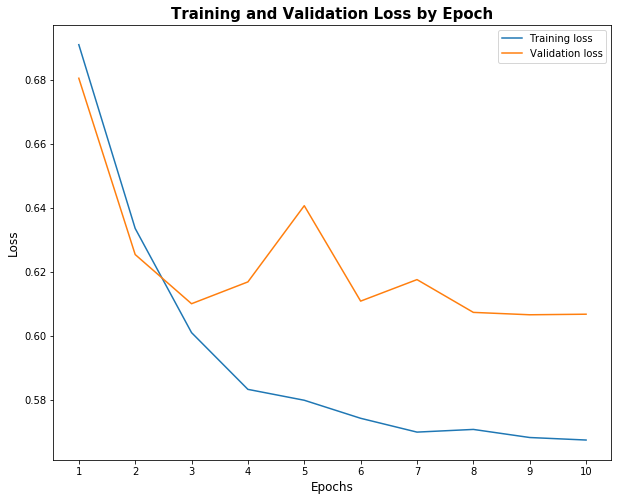

In [125]:
#Plot the training and validation loss by epoch

plt.figure(figsize=(10,8))
epochs = range(1,11)
plt.plot(epochs, history.history['loss'], label='Training loss')
plt.plot(epochs, history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss by Epoch', size=15, weight='bold')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.xticks(np.arange(1,11,1))
plt.legend();

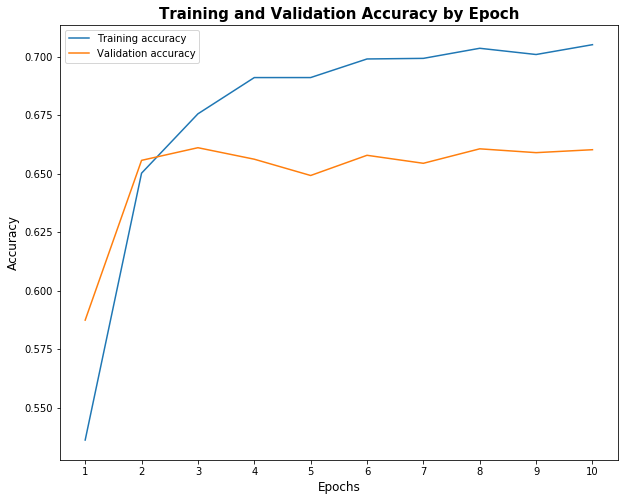

In [126]:
# Plot the training and validation accuracy by epoch

plt.figure(figsize=(10,8))
epochs = range(1,11)
plt.plot(epochs, history.history['accuracy'], label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy by Epoch', size=15, weight='bold')
plt.xlabel('Epochs', size=12)
plt.ylabel('Accuracy', size=12)
plt.xticks(np.arange(1,11,1))
plt.legend();

## Loading a check-pointed model

In [127]:
# Load weights
model.load_weights('./output/model-03-0.661.hdf5')

In [128]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [129]:
# Generate predictions on validation set
class_preds = (model.predict(X_val_padded) > 0.5).astype(int)

In [130]:
val_preds = []

# Loop through the class prediction list and append the predictions to val_preds
for i in class_preds:
    val_preds.append(i[0][0])

# Convert val_preds to a series
val_preds = pd.Series(val_preds)

In [131]:
# Accuracy scores
print('Accuracy score on training set: ', model.evaluate(X_train_padded, y_train_list, verbose=0)[1])
print('Accuracy score on validation set: ', model.evaluate(X_val_padded, y_val_list, verbose=0)[1])
print('')

# Print classification report and confusion matrix for validation set
cmat(y_val, val_preds, 'validation set')

Accuracy score on training set:  0.7120724320411682
Accuracy score on validation set:  0.6610608100891113

Classification report for validation set
              precision    recall  f1-score   support

           0       0.63      0.68      0.66      1290
           1       0.68      0.63      0.65      1362

    accuracy                           0.65      2652
   macro avg       0.66      0.66      0.65      2652
weighted avg       0.66      0.65      0.65      2652


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        880                        410
Actual Negative Review                        506                        856


# Model Evaluation: Summary Metrics

|                                                             	| Accuracy on Training Set 	| Accuracy on Validation Set 	| Recall on Validation Set 	|
|:-------------------------------------------------------------	|:--------------------------:	|:----------------------------:	|:--------------------------:	|
| TF-IDF & SVC                                                	| 0.7058                    	| 0.6655                      	| 0.63                     	|
| Count Vectorizer & Naïve Bayes                              	| 0.6799                    	| 0.6535                      	| 0.74                     	|
| Bidirectional LSTM                                          	| 0.7121                    	| 0.6611                      	| 0.63                     	|
| TF-IDF & Logistic Regression                                	| 0.6702                    	| 0.6455                      	| 0.71                     	|
| TF-IDF & Naïve Bayes                                        	| 0.6851                    	| 0.6640                      	| 0.73                     	|
| Count Vectorizer & SVC                                      	| 0.6685                    	| 0.6425                      	| 0.60                     	|
| Count Vectorizer & Logistic Regression                      	| 0.6656                    	| 0.6452                      	| 0.72                     	|

# Production Model's Most Predictive Words

In [152]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
svc_coef = pd.DataFrame(gs_tvec_svc.best_estimator_.named_steps['tvec'].get_feature_names(), columns=['word'])

In [153]:
# Coefficients
svc_coef['coef'] = gs_tvec_svc.best_estimator_.named_steps['svc'].coef_.toarray()[0]

In [189]:
svc_coef.sort_values(by='coef').head()

,word,coef
613,okay,-1.321011
86,boring,-1.319550
200,decent,-1.314406
612,ok,-1.309870
49,bad,-1.257564


In [190]:
svc_coef.sort_values(by='coef').tail()

,word,coef
23,amazing,1.454343
45,awesome,1.533220
323,favorite,1.762709
385,great,2.124807
520,love,2.231962


In [183]:
# Top words related to negative sentiment (class 0)
neg_sent_svc = svc_coef.sort_values(by='coef').head(10)

# Top words related to positive sentiment (class 1)
pos_sent_svc = svc_coef.sort_values(by='coef').tail(10)

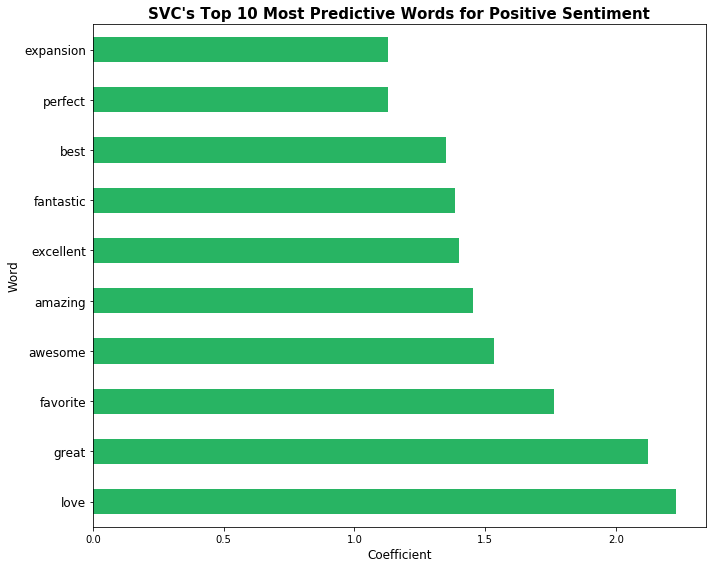

In [186]:
pos_sent_svc.sort_values('coef', ascending=False).plot(x='word', y='coef', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("SVC's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

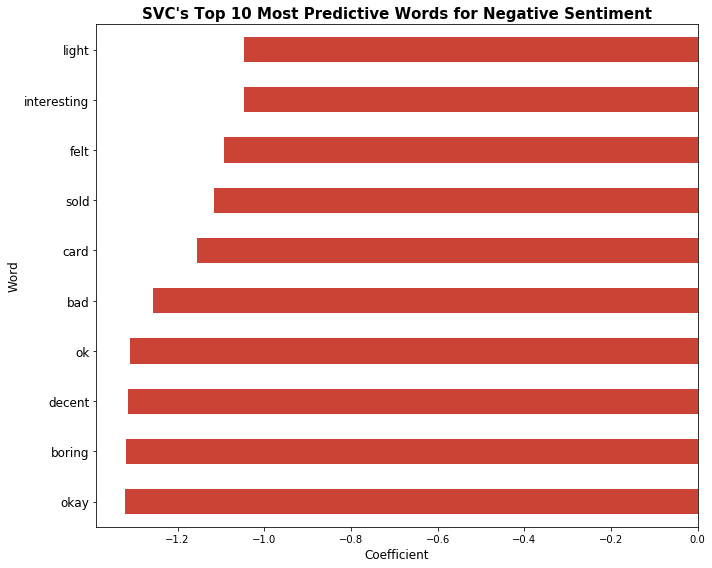

In [187]:
neg_sent_svc.plot(x='word', y='coef', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("SVC's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

# Evaluate Production Model on Test Set

In [133]:
# Read test set into a dataframe
test = pd.read_csv('./datasets/clean_test.csv')

In [134]:
# There are 3315 documents in our test set
test.shape

(3315, 7)

In [135]:
# The class representation in our test set looks similar to our training set as we used stratify
test['target'].value_counts(normalize=True)

1    0.513424
0    0.486576
Name: target, dtype: float64

In [136]:
# Establish our X and y variables
X_test = test['comment_clean']
y_test = test['target']

In [137]:
test_pred = gs_tvec_svc.predict(X_test)

In [138]:
print('Evaluation metrics for test set')
print('')
print('Accuracy score: ', accuracy_score(y_test, test_pred))
print('')

# Print classification report and confusion matrix
cmat(y_test, test_pred, 'test set')

Evaluation metrics for test set

Accuracy score:  0.6690799396681749

Classification report for test set
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1613
           1       0.70      0.63      0.66      1702

    accuracy                           0.67      3315
   macro avg       0.67      0.67      0.67      3315
weighted avg       0.67      0.67      0.67      3315


Confusion matrix for test set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                       1141                        472
Actual Negative Review                        625                       1077


## Success Evaluation

Given that our production model achieves 0.67 on accuracy, higher than our baseline model of 0.51 and 0.63 on recall, we can conclude that the model generalises well on unseen data.